## Serialization strategy
Model parameters, optimizer state, and metadata are serialized using Python pickle.
Pickle is sufficient for small to medium Python objects and rapid prototyping.

For large arrays or cross-language compatibility, formats such as HDF5 would be preferred.
Checkpoints are stored under models/ as model_<track>_<nqubits>.pkl.


In [2]:
import pickle
from pathlib import Path

def save_pickle(obj, path):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "wb") as f:
        pickle.dump(obj, f)

def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def demonstrate_serialization_roundtrip():
    test_obj = {"a": 1, "b": [1,2,3]}
    save_pickle(test_obj, "models/test_roundtrip.pkl")
    return load_pickle("models/test_roundtrip.pkl")

demonstrate_serialization_roundtrip()


{'a': 1, 'b': [1, 2, 3]}

In [4]:
import numpy as np

class QuantumModel:
    def __init__(self, n_qubits, n_layers=1, params=None, seed=None):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.dim = 2 ** n_qubits
        self.rng = np.random.default_rng(seed)
        self.params = params if params is not None else self.rng.normal(size=self.dim)

    def statevector(self):
        psi = self.params.astype(complex)
        psi = psi / np.linalg.norm(psi)
        return psi

    def fidelity_with(self, target_state):
        psi = self.statevector()
        return np.abs(np.vdot(psi, target_state))**2

    def save(self, path):
        save_pickle(self, path)

    @staticmethod
    def load(path):
        return load_pickle(path)


In [6]:
m = QuantumModel(n_qubits=3, seed=0)
psi = m.statevector()
m.save("models/model_test_3.pkl")
m2 = QuantumModel.load("models/model_test_3.pkl")
np.allclose(psi, m2.statevector())


True

In [8]:
import time

def random_pure_state(dim, rng):
    psi = rng.normal(size=dim) + 1j*rng.normal(size=dim)
    return psi / np.linalg.norm(psi)

def scalability_experiment(qubit_list, trials=5, seed=0):
    rng = np.random.default_rng(seed)
    summary = []

    for n in qubit_list:
        fidelities = []
        times = []

        for _ in range(trials):
            target = random_pure_state(2**n, rng)
            model = QuantumModel(n_qubits=n, seed=rng.integers(1e9))

            start = time.time()
            F = model.fidelity_with(target)
            elapsed = time.time() - start

            fidelities.append(F)
            times.append(elapsed)

        summary.append({
            "n_qubits": n,
            "mean_fidelity": np.mean(fidelities),
            "std_fidelity": np.std(fidelities),
            "mean_runtime": np.mean(times)
        })

    return summary

def save_scalability_summary(summary, path="scalability_results.csv"):
    import csv
    with open(path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=summary[0].keys())
        writer.writeheader()
        writer.writerows(summary)

summary = scalability_experiment([2,3,4,5])
save_scalability_summary(summary)
summary

[{'n_qubits': 2,
  'mean_fidelity': 0.26488325785676836,
  'std_fidelity': 0.23980959075099506,
  'mean_runtime': 0.00039081573486328126},
 {'n_qubits': 3,
  'mean_fidelity': 0.1633292268291525,
  'std_fidelity': 0.1091337592245032,
  'mean_runtime': 0.00020155906677246093},
 {'n_qubits': 4,
  'mean_fidelity': 0.08652488025015234,
  'std_fidelity': 0.06989934381607257,
  'mean_runtime': 0.0},
 {'n_qubits': 5,
  'mean_fidelity': 0.03162275483282989,
  'std_fidelity': 0.030567970128091176,
  'mean_runtime': 0.00020155906677246093}]

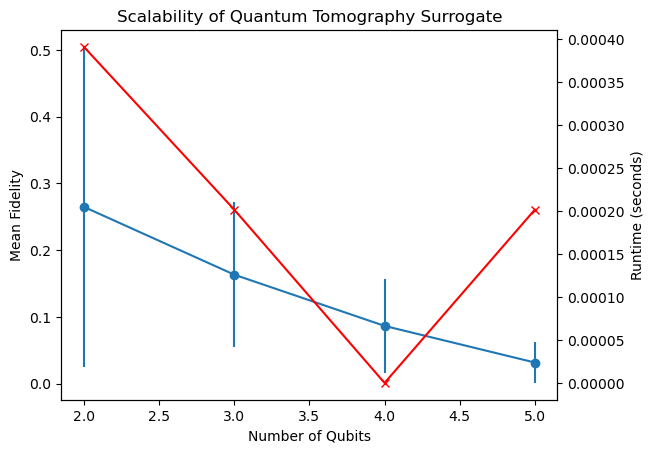

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_scalability(csv_path="scalability_results.csv"):
    df = pd.read_csv(csv_path)

    fig, ax1 = plt.subplots()

    ax1.errorbar(df["n_qubits"], df["mean_fidelity"],
                 yerr=df["std_fidelity"], marker="o")
    ax1.set_xlabel("Number of Qubits")
    ax1.set_ylabel("Mean Fidelity")

    ax2 = ax1.twinx()
    ax2.plot(df["n_qubits"], df["mean_runtime"], color="red", marker="x")
    ax2.set_ylabel("Runtime (seconds)")

    plt.title("Scalability of Quantum Tomography Surrogate")
    plt.show()

plot_scalability()

## Ablation plan
Hypothesis: Increasing model depth increases expressibility but slows runtime.
Metric: Mean fidelity and variance across random seed.


In [13]:
def ablation_layers(n_qubits=3, layer_list=[1,2,4], trials=10, seed=0):
    rng = np.random.default_rng(seed)
    results = []

    for layers in layer_list:
        fidelities = []
        for _ in range(trials):
            target = random_pure_state(2**n_qubits, rng)
            model = QuantumModel(n_qubits=n_qubits, n_layers=layers, seed=rng.integers(1e9))
            fidelities.append(model.fidelity_with(target))

        results.append({
            "layers": layers,
            "mean_fidelity": np.mean(fidelities),
            "std_fidelity": np.std(fidelities)
        })

    return results

ablation_results = ablation_layers()
ablation_results


[{'layers': 1,
  'mean_fidelity': 0.09559272635481113,
  'std_fidelity': 0.07628175845860197},
 {'layers': 2,
  'mean_fidelity': 0.1357896910551272,
  'std_fidelity': 0.1218986537172382},
 {'layers': 4,
  'mean_fidelity': 0.167476858462396,
  'std_fidelity': 0.12355970009070621}]

## Reflection
Scalability is limited by exponential state dimension.
Runtime increases rapidly beyond 5 qubits.
Simple surrogate models are useful for benchmarking before full tomography.
Future work includes classical shadows and hardware experimets.
